## Reproject coordinate array values

In this python we aim to take the values from two arrays, 'longitude' and 'latitude' and treating each corresponding value as a coordinate pair reproject to a local map projection. 

(No need to question why this is necessary, it's for a project where I need this exact result - I'm merely concerned about the style in which I do it). 

The NetCDF file with longitude,latitude arrays `shape = (2030, 1354)` is downloaded from NASA ocean colour (we can't address it directly via URL as the getfile mechanism does not support range requests, and please note also we need Earthdata creds to access the file). 

We open the tree, and isolate the '/navigation_data' group which has longitude and latitude. Then 

- reshape the values into a matrix of longitude,latitude pairs
- define a local projection from a central coordinate
- reproject with pyproj in a function `project_array()`
- set up 'x' and 'y' DataArrays with the same properties as 'longitude' and 'latitude' and fill with the projected values

My question is, what is the most xarray-idiomatic way to do this? Is there anything especially wrong with the style here of how the reprojection is done? 

I know that copying the longitude,latitude to fill with x,y is not ideal but I'm less concerned about that. Is there a better way to do the raw coordinate reprojection, but if there's input into how the new arrays are added that will also help a lot. Thanks!  Michael Sumner, mdsumner@gmail.com



In [ ]:
oc = "http://oceandata.sci.gsfc.nasa.gov/getfile/AQUA_MODIS.20250704T003501.L2.OC.NRT.nc"
#not sure how to automate this, but 11Mb file at this URL needs earthdata Auth
#!wget --header="Authorization: Bearer ey..." http://oceandata.sci.gsfc.nasa.gov/getfile/AQUA_MODIS.20250704T003501.L2.OC.NRT.nc

import xarray
import os
ds = xarray.open_datatree(os.path.basename(oc)).navigation_data
ds.longitude.shape


In [10]:
from pyproj import Transformer
import numpy

def project_array(coordinates, target = 'EPSG:3412', source = 'EPSG:4326'):
    """
    Project a numpy (n,2) array in projection source to projection target
    Returns a numpy (n,2) array.
    Adpated from Uli Kohler https://stackoverflow.com/a/42459069
    """
    transformer = Transformer.from_crs(source, target, always_xy = True)
    fx, fy = transformer.transform(coordinates[:,0], coordinates[:,1])
    # Re-create (n,2) coordinates
    return numpy.dstack([fx, fy])[0]


ll = numpy.dstack([ds.longitude.values.flatten(), ds.latitude.values.flatten()])[0]
ll[0:9, :]


array([[-83.80194 , -68.893936],
       [-83.8573  , -68.93313 ],
       [-83.91242 , -68.972   ],
       [-83.9673  , -69.010544],
       [-84.02195 , -69.048775],
       [-84.07637 , -69.0867  ],
       [-84.13056 , -69.12431 ],
       [-84.184525, -69.16163 ],
       [-84.238266, -69.19865 ]], dtype=float32)

In [11]:
## generate a local crs
crs = f'+proj=laea +lon_0={int(ds.longitude.values.mean())} +lat_0={int(ds.latitude.values.mean())} +datum=WGS84 +type=crs'
coords = project_array(ll, target = crs)
print(coords[0:10, :])
ds.x = ds.longitude  ## make a copy
ds.y = ds.latitude
shape = ds.x.shape
shape = (shape[1], shape[0])
ds.x.values = numpy.reshape(coords[:, 0].astype(ds.x.dtype), shape, order = "F").transpose()
ds.y.values = numpy.reshape(coords[:, 1].astype(ds.y.dtype), shape, order = "F").transpose()

[[1498274.36460291 -499480.30654632]
 [1493859.39994819 -501616.22371716]
 [1489478.2679522  -503735.37919181]
 [1485131.64614752 -505837.17013091]
 [1480817.93628086 -507922.47965316]
 [1476536.54241736 -509991.88662682]
 [1472287.90538901 -512044.60723092]
 [1468070.91391826 -514081.9053442 ]
 [1463885.25515381 -516103.49887976]
 [1459730.85548648 -518109.29119567]]


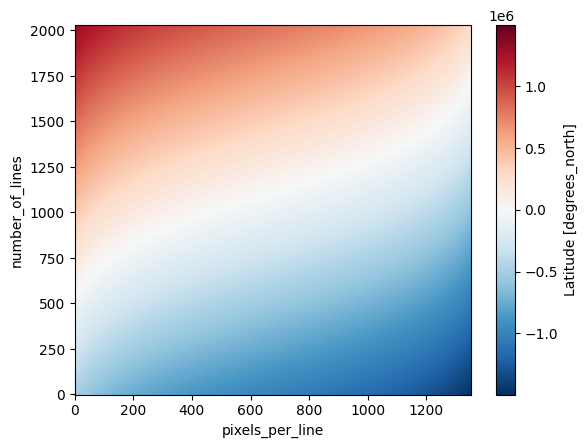

In [13]:
ds.y.plot()
